## Проект. Принятие решений в бизнесе.


### Описание проекта

Есть данные крупного интернет-магазина. Вместе с отделом маркетинга мы подготовили список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты. 

#### Описание данных

В нашем распоряжении три датасета. В файле hypothesis.csv 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.

Структура hypothesis.csv:
  - Hypothesis — краткое описание гипотезы;
  - Reach — охват пользователей по 10-балльной шкале;
  - Impact — влияние на пользователей по 10-балльной шкале;
  - Confidence — уверенность в гипотезе по 10-балльной шкале;
  - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.
  
Файлы orders.csv и visitors.csv содержат результаты проведенного A/B тестирования. В файле orders.csv содержится информация о пользователях совершивших заказы и выручки по ним. Файл visitors.csv хранит данные о количестве пользователей в указанную дату в указанной группе A/B-теста.

Структура orders.csv:

   - transactionId — идентификатор заказа;
   - visitorId — идентификатор пользователя, совершившего заказ;
   - date — дата, когда был совершён заказ;
   - revenue — выручка заказа;
   - group — группа A/B-теста, в которую попал заказ.

Структура visitors.csv:

   - date — дата;
   - group — группа A/B-теста;
   - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt, timedelta
# import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

#### Загрузка данных.

In [3]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv', sep=',') # читаем csv-файл
orders = pd.read_csv('/datasets/orders.csv', sep=',') # читаем csv-файл
visitors = pd.read_csv('/datasets/visitors.csv', sep=',') # читаем csv-файл

#### Выведим строки датафрэйма hypothesis. Изучим общую информацию о наборе данных.

In [4]:
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [5]:
# получение общей информации о данных из датафрейма
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В данных нет пропусков, типы данных соответствуют значениям. Названия столбцов стоит переименовать в стиле змеиного регистра. 

In [6]:
# заменим названия столбцов в нижнем регистре
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Наименования столбцов соответствуют нормам. С датафрэймом можно продолжить работу.

#### Выведим первые строки датафрэйма orders. Изучите общую информацию о наборе данных.

In [7]:
orders.head(10)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [8]:
# получение общей информации о данных из датафрейма
orders.info()
# проверим датафрэйм на наличие явных дубликатов
orders.duplicated().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


0

В данных нет пропусков и явных дубликатов. В столбце `date` тип данных `object`, преобразуем значения в формат даты. Названия столбцов стоит переименовать в стиле змеиного регистра. 

In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.strptime(x, '%Y-%m-%d')
)

# заменим названия столбцов в нижнем регистре
orders.columns = orders.columns.str.lower()

# получение общей информации о данных из датафрейма
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


#### Проверим корректность разбиения пользователей на группы.

Проверим корректность разбиения пользователей на группы - может быть есть пользователи, попавшие в обе группы? Если такие пользователи есть, то нужно их выявить и выработать стратегию работы с такими данными. Пересечение групп сильно влияет на результаты теста, если процент достаточно большой.

In [10]:
# Сгруппируем пользователей попавших в обе группе
orders.groupby('visitorid').agg({'group' : 'nunique'}).query('group>1').count()

group    58
dtype: int64

Таких пользователей всего 58. Удалим их из датасэта.

In [11]:
# создаем список пользователей с visitorid встречающихся в обеих группах.
double_users = (
    orders.groupby("visitorid")
    .agg({"group": "nunique"})
    .reset_index()
    .query("group>1")["visitorid"]
    .unique()
)
# удаляем этих пользователей из таблицы orders:
orders = orders.query('visitorid not in @double_users')
# проверим общую информацию о таблице orders после удаления дублей
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB


Все значения соответствуют необходимым типам данных. Дубли, всречающиеся в обоих группах теста удалены.

#### Выведим первые строки датафрэйма visitors. Изучите общую информацию о наборе данных.

In [12]:
visitors.head(10)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [13]:
# получение общей информации о данных из датафрейма
visitors.info()
# проверим датафрэйм на наличие явных дубликатов
visitors.duplicated().sum() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


0

В данных нет пропусков и явных дубликатов. В столбце `date` тип данных `object`, преобразуем значения в формат даты. 

In [14]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.strptime(x, '%Y-%m-%d')
)
# получение общей информации о данных из датафрейма
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Все значения соответствуют необходимым типам данных.

## Часть 1. Приоритизация гипотез.

#### Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

ICE (от англ. impact, confidence, effort / ease «влияние, уверенность, усилия / простота») — один из самых популярных способов приоритизации задач: 
  - Параметр Effort показывает сколько стоит протестировать эту гипотезу. 
  - Параметр Impact показывает, насколько сильно изменение повлияет на охваченных пользователей.
  - Параметр Confidence показывает, насколько вы уверены в оценках других параметров. 
Все параметры оценены по 10 бальной шкале.

In [15]:
# Добавим полученные значения ICE к существующей таблице. Новый столбец назовем ICE. Значения не округляем.
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']

# Выведим столбцы 'hypothesis' и 'ICE', отсортированные по столбцу 'ICE'.
hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по ICE: 
 - 9 - Запустить акцию, дающую скидку на товар в день рождения,
 - 1 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей, 
 - 8 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
 - 7 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

#### Примените фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

RICE — это метод приоритизации идей и фич продукта. Аббревиатура включает 4 фактора, которые менеджер продукта может смело использовать для оценки и приоритизации продуктовых фич:

   - Reach — это охват
   - Impact — влияние
   - Confidence — уверенность в вашей оценке охвата, влияния и трудозатрат
   - Effort — трудозатраты

Чтобы получить оценку по RICE, вам необходимо объединить эти факторы.

In [16]:
# Добавим полученные значения RICE к существующей таблице. Новый столбец назовем RICE. Значения не округляем.
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']/hypothesis['efforts']

# Выведим столбцы 'hypothesis' и 'RICE', отсортированные по столбцу 'RICE'.
#hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


Картина изменилась. Теперь наиболее перспективные гипотезы:
  - 8 -Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
  - 3 -Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
  - 1 -Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
  - 7 -Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

При оценки приоритетов гипотез методом RICE на первые места вышли гипотезы под номерами 8 и 3. так получилось, потому что ее параметр Reach равен 10 и 8 соответственно, в то время как у других гипотез он меньше. Так как кроме силы гипотез, нужно учитывать и то, сколько пользователей она затронет.

Запустить акцию, дающую скидку на товар в день рождения - имеет сильное влияние на пользователей, но охватывает не значительную их часть. Показатель  Reach всего лишь 1.

## Часть 2. Анализ A/B-теста

Мы провели A/B-тест и получили результаты, которые описаны в файлах /datasets/orders.csv и /datasets/visitors.csv.

#### Соберем кумулятивные данные в одну таблицу. Объявим датафрейм `cumulativeData`.

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм `cumulativeData` со столбцами: 

    date — дата;
    group — группа A/B-теста (A или B);
    orders — кумулятивное количество заказов на указанную дату в указанной группе;
    buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
    revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
    visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

Создадим массив уникальных пар значений дат и групп теста методом drop_duplicates(): 

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах в несколько действий. 
Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, а группа теста равна группе из datesGroups:
orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].
Агрегируем значения. Вычислим максимальную дату. Для группы тоже рассчитаем максимум, и хотя она будет определённой, сделаем это, чтобы столбец 'group' не пропал из итогового вывода. Найдём число уникальных ID заказов и пользователей. Подсчитаем сумму средних чеков:
.agg({'date' : 'max', 'group' : 'max', 'orderId' : 'nunique', 'userId' : 'nunique', 'revenue' : 'sum'}). Применим методы к каждой строке датафрейма: apply(axis=1) и отсортируем результаты по столбцам 'date' и 'group': 

In [18]:
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(orders["date"] <= x["date"], orders["group"] == x["group"])
    ].agg(
        {
            "date": "max",
            "group": "max",
            "transactionid": "nunique",
            "visitorid": "nunique",
            "revenue": "sum",
        }
    ),
    axis=1,
).sort_values(by=["date", "group"])

Аналогично получим агрегированные кумулятивные по дням данные о пользователях.

In [19]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(visitors["date"] <= x["date"], visitors["group"] == x["group"])
    ].agg({"date": "max", "group": "max", "visitors": "sum"}),
    axis=1,
).sort_values(by=["date", "group"])

Объединим обе таблицы в одну с понятными названиями столбцов: 

In [20]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=["date", "group"], right_on=["date", "group"]
)
cumulativeData.columns = ["date", "group", "orders", "buyers", "revenue", "visitors"]

print(cumulativeData.head(6))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845
5 2019-08-03     B      54      53   288850      1803


Теперь на основе этой таблицы можно строить графики.

#### Построим график кумулятивной выручки по группам. 

Построим графики кумулятивной выручки по дням и группам A/B-тестирования: 

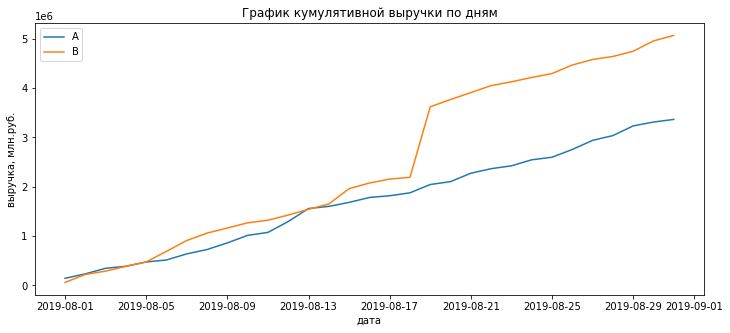

In [21]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,5))
plt.title('График кумулятивной выручки по дням')
plt.ylabel('выручка, млн.руб.')
plt.xlabel('дата')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()
plt.show()

Выручка почти равномерно увеличивается в течение всего теста. Хороший знак.
В середине теста сегмент В вырвался вперёд и продолжал лидировать весь остаток теста. Это может сигнализировать о всплеске числа заказов, либо о появлении аномально больших заказов в выборке. Такие выбросы всё-таки влияют на результаты. При заключительном анализе их нужно удалить.

#### Для каждой группы построим графики кумулятивного среднего чека по дням.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

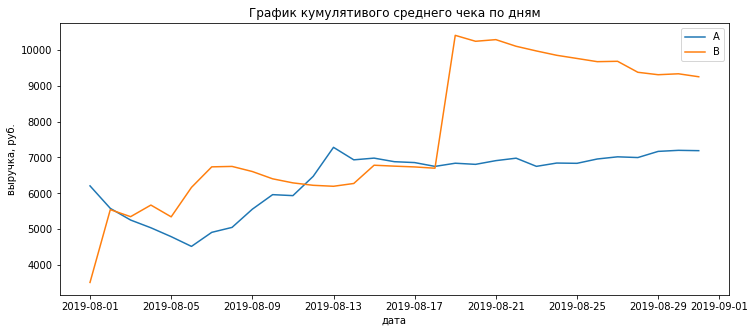

In [22]:
plt.figure(figsize=(12,5))
plt.ylabel('выручка, руб.')
plt.title('График кумулятивого среднего чека по дням')
plt.xlabel('дата')

plt.plot(
    cumulativeRevenueA["date"],
    cumulativeRevenueA["revenue"] / cumulativeRevenueA["orders"],
    label="A",
)
plt.plot(
    cumulativeRevenueB["date"],
    cumulativeRevenueB["revenue"] / cumulativeRevenueB["orders"],
    label="B",
)
plt.legend()
plt.show()

Средний чек становится равномерным ближе к концу теста: установился для группы A и продолжает падать для группы B. Возможно, в группу B в середине теста попали крупные заказы (резкий всплеск на графике). Скорее всего, принимать решение по этой метрике рано. Или требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

#### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis*, «горизонтальная линия поперек оси»):

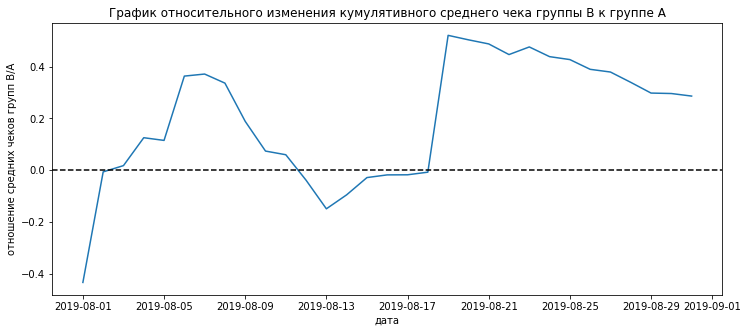

In [23]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on="date", right_on="date", how="left", suffixes=["A", "B"]
)

plt.figure(figsize=(12,5))
plt.ylabel('отношение средних чеков групп В/А')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')

# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue["date"],
    (mergedCumulativeRevenue["revenueB"] / mergedCumulativeRevenue["ordersB"])
    / (mergedCumulativeRevenue["revenueA"] / mergedCumulativeRevenue["ordersA"])
    - 1,
)

# добавляем ось X
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Где-то уж точно спрятались крупные заказы и выбросы! Найдём их дальше.

#### Построим график кумулятивного среднего количества заказов на посетителя по группам.

Аналогично проанализируем график кумулятивного среднего количества заказов на посетителя по группам. 

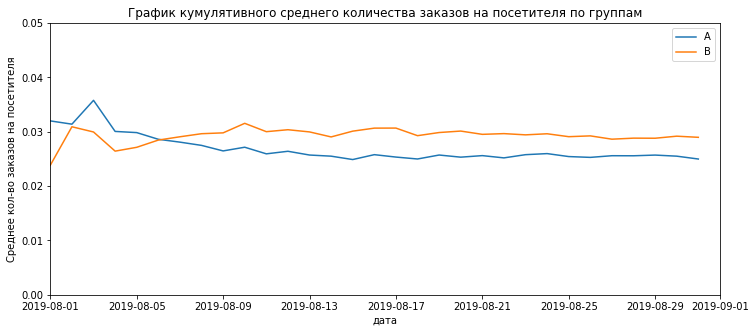

In [24]:
# считаем среднее количество заказов на посетителя
cumulativeData["conversion"] = cumulativeData["orders"] / cumulativeData["visitors"]

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData["group"] == "A"]

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData["group"] == "B"]

# строим графики
plt.figure(figsize=(12,5))
plt.ylabel('Среднее кол-во заказов на посетителя')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('дата')


plt.plot(cumulativeDataA["date"], cumulativeDataA["conversion"], label="A")
plt.plot(cumulativeDataB["date"], cumulativeDataB["conversion"], label="B")
plt.legend()
# задаем масштаб осей
plt.axis([dt(2019, 8, 1), dt(2019, 9, 1), 0, 0.05])
plt.show()

Симметричный график получился! Группы колебались в начале теста. Но затем у группы В среднее количество заказов вырвалось вперёд и зафиксировалось, а у группы А — просело, но тоже зафиксировалось.

  Мы изменили масштаб графика, чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое: от 2% до 4%. В относительных величинах — это почти в 2 раза. Потому, если убрать масштаб осей, будет казаться, что колебания продолжаются, и среднее количество заказов по группам не установилось около своего среднего значения.

#### Построим график изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

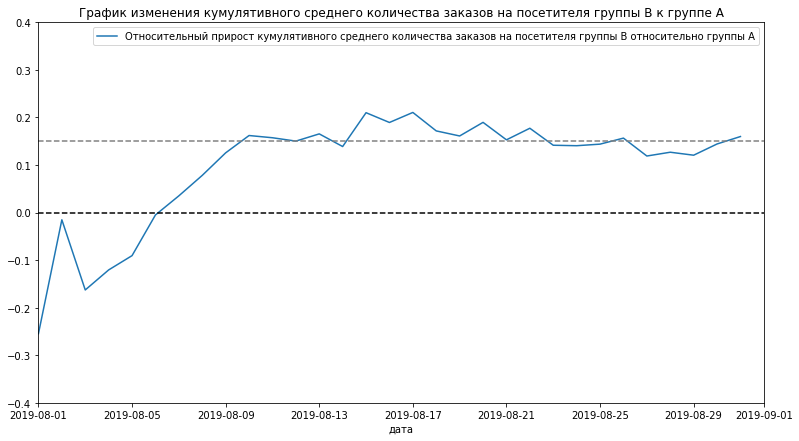

In [25]:
mergedCumulativeConversions = cumulativeDataA[["date", "conversion"]].merge(
    cumulativeDataB[["date", "conversion"]],
    left_on="date",
    right_on="date",
    how="left",
    suffixes=["A", "B"],
)
plt.figure(figsize=(13,7))
plt.title('График изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('дата')

plt.plot(
    mergedCumulativeConversions["date"],
    mergedCumulativeConversions["conversionB"]
    / mergedCumulativeConversions["conversionA"]
    - 1,
    label="Относительный прирост кумулятивного среднего количества заказов на посетителя группы B относительно группы A",
)
plt.legend()

plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=0.15, color="grey", linestyle="--")
# задаем масштаб осей
plt.axis([dt(2019, 8, 1), dt(2019, 9, 1), -0.4, 0.4])
plt.show()

Мы построили график относительного различия метрик между группами.
Почти с самого начала теста группа В лидирует по метрике: становится лучше и лучше, либо зафиксировалась около прироста в 15% относительно группы А.

#### Построим точечный график количества заказов по пользователям. 

Проверим данные на аномалии, которые могут искажать результаты A/B-теста. Напомним, что аномалия — такое значение, которое бывает в генеральной совокупности редко, но его попадание в выборку способно внести погрешность. 
Изучим данные о заказах.

Найдем число заказов по пользователям — создадим датафрейм c двумя столбцами: 'userid' и 'orders'. Назовем его ordersByUsers. Отсортируем по убыванию количества заказов пользователей и выведите на экран первые 10 строк

In [26]:
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)
ordersByUsers.columns = ['userid', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

         userid  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


Максимальное количество заказов одним пользователем - 3.
Построим точечную диаграмму числа заказов на одного пользователя:

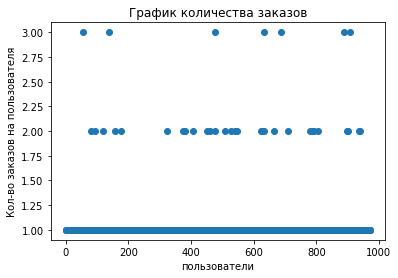

In [27]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.ylabel('Кол-во заказов на пользователя')
plt.title('График количества заказов')
plt.xlabel('пользователи')

plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Выводы подтверждаются: много пользователей с 1-3 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет. 
Посчитаем выборочные перцентили количества заказов на одного пользователя:

#### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей.

Посчитайте 95-й и 99-й выборочные перцентили количества заказов по пользователям методом np.percentile(). Результат выведим на экран.

In [28]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей оформляли больше чем 2 заказов. И 1% пользователей заказывали 3 раза. 
Разумно выбрать 3 заказа на одного пользователя за верхнюю границу числа заказов, в таком случае в данных выбросов нет.

#### Построим точечный график стоимости заказов.

Если очень дорогой заказ попадёт в одну из групп теста, он сразу же исказит результаты и сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно.
Такие аномально дорогие заказы следует удалять из теста. Можно провести и анализ самых дешёвых заказов. Однако из-за маленькой стоимости они слабо влияют на средний чек.  

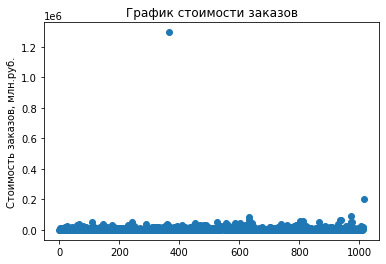

In [29]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.ylabel('Стоимость заказов, млн.руб.')
plt.title('График стоимости заказов')
plt.scatter(x_values, orders['revenue'])

Всё, как предполагали: есть всего два очень дорогих заказа. По графику можно выбрать границу аномальных заказов около 20 000 рублей. Однако принято отсеивать от 1% до 5% наблюдений с крайними значениями. 

#### Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

Посчитаем 95-й и 99-й выборочные перцентили выручки с заказов по пользователям методом np.percentile(). 

In [30]:
np.percentile(orders['revenue'],[95, 99])

array([26785., 53904.])

Не более, чем у 5% заказов чек дороже 26 785 рублей. И не больше, чем у 1% заказов - дороже 53 904 рублей.
Красиво жить не запретишь. По крайней мере, одному проценту пользователей.
Скорректируем верхнюю границу до  26 700 рублей. И все заказы выше отбросим, как аномальные.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным, без удаления аномальных значений.
Сформулируем гипотезы. 
  - H0 - Нет  различий в среднем количестве заказов между группами. 
  - H1 - Есть различия в среднем между группами.
Начнём с подготовки данных.

In [31]:
# сбрасываем настройки отображения столбцов по умолчанию
pd.reset_option('display.max_columns')
pd.reset_option('max_colwidth')
pd.reset_option('display.width')

# количество пользователей в указанную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей в указанную дату в группе A с накоплением
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# количество пользователей в указанную дату в группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей в указанную дату в группе В с накоплением
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# количество заказов в указанную дату в группе А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# количество заказов в указанную дату в группе А с накоплением
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

# количество заказов в указанную дату в группе В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

# количество заказов в указанную дату в группе В с накоплением
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

# формируем итоговую таблицу
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Названия столбцов данных:

    date — дата;
    ordersPerDateA — количество заказов в выбранную дату в группе A;
    revenuePerDateA — суммарная выручка в выбранную дату в группе A;
    ordersPerDateB — количество заказов в выбранную дату в группе B;
    revenuePerDateB — суммарная выручка в выбранную дату в группе B;
    ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
    revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
    ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
    revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
    visitorsPerDateA — количество пользователей в выбранную дату в группе A;
    visitorsPerDateB — количество пользователей в выбранную дату в группе B;
    visitorsCummulativeA  — количество пользователей до выбранной даты включительно в группе A;
    visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [32]:
# количество заказов совершенных отдельными пользователями в группе А
ordersByUsersA = (
    orders[orders["group"] == "A"]
    .groupby("visitorid", as_index=False)
    .agg({"transactionid": pd.Series.nunique})
)
ordersByUsersA.columns = ["userid", "orders"]

# количество заказов совершенных отдельными пользователями в группе В
ordersByUsersB = (
    orders[orders["group"] == "B"]
    .groupby("visitorid", as_index=False)
    .agg({"transactionid": pd.Series.nunique})
)
ordersByUsersB.columns = ["userid", "orders"]

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

In [33]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value =', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.01102
0.160


P-value меньше 0.05, поэтому нулевую гипотезу отвергаем. Анализ «сырых данных» сообщает, что в среднем количестве заказов между группами есть статистически значимые различия. Относительный прирост среднего группы В к конверсии группы А равен 16.0%.
Осталось сравнить средние чеки по «сырым данным», а затем обе метрики ещё раз после удаления выбросов.

#### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 
Сформулируем гипотезы. 
  - H0 - Нет  различий в среднем чеке между группами . 
  - H1 - Есть различия в среднем чеке между группами .
 
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов. 

А ещё найдём относительные различия в среднем чеке между группами:

In [34]:
print('p-value =', 
    "{0:.3f}".format(
        stats.mannwhitneyu(
            orders[orders["group"] == "A"]["revenue"],
            orders[orders["group"] == "B"]["revenue"],
        )[1]
    )
)

display(
    "{0:.3f}".format(
        orders[orders["group"] == "B"]["revenue"].mean()
        / orders[orders["group"] == "A"]["revenue"].mean()
        - 1
    )
)

p-value = 0.829


'0.287'

Наблюдаемое различие между группами в 28,7% не является статистически значимым, так как P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. 

Проанализируем аномалии.

#### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным. 

Примем за аномальных пользователей тех, кто совершил заказ дороже 26 700 рублей (95-й персентиль)
Так мы уберём 5% пользователей с дорогими заказами. Объявим переменную - abnormalUsers, и вклюим в нее только дорогие заказы.

Узнаем, сколько всего аномальных пользователей атрибутом shape.

In [35]:
# пользователи совершившие заказы дороже верхней границы
revenue_lim = np.percentile(orders['revenue'], 95)

abnormalUsers = (
    orders[orders["revenue"] > revenue_lim]["visitorid"]
    .drop_duplicates()
    .sort_values()
)

display(abnormalUsers.head(5), abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
684     358944393
648     382846391
Name: visitorid, dtype: int64

51

Всего 51 пользователm с аномально дорогими заказами.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [37]:
print('p-value =', "{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value = 0.017
0.156


Как и в случае с сырыми данными статистическая значимость достигнута, сегмент В лучше, чем сегмент А. Относительный прирост среднего группы В к конверсии группы А равен 15.6%

#### Посчитаем статистическую значимость различия средних чеков после удаления аномальных пользователей.

Выведим p-value для сравнения средних чеков между очищенными группами. Округлим p-value до трёх знаков после запятой. Выведим относительный прирост среднего чека очищенной группы B, округлив до трёх знаков после запятой.

In [38]:
print('p-value =', 
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value = 0.741
-0.053


После удаления выбросов разница между сегментами сократилась с 28.7% до 5%, то есть практически отсутствует. Это и подтверждается значением p-value, значительно выше 0.05. Значит разница между сегментами в 5%, является статистически не значимой. Нет причин отвергать нулевую гипотезу.

### Решение по результатм А/В теста.

Можно сделать следующие выводы по результатам анализа:

  - Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. Сегмент В лучше, чем сегмент А. Относительный прирост среднего группы В к конверсии группы А равен 15.6% по очищенным данным.
  - По сырым данным нет статистически значимого различия по среднему чеку между группами. После удаления аномалий ситуация не изменилась.  Разница между сегментами сократилась до 5%, и не является статистически значимой.
  - График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения.

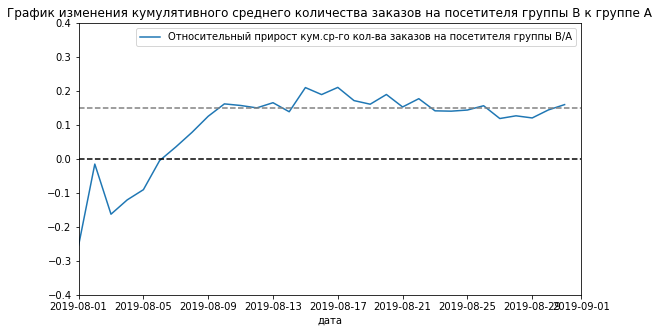

In [39]:
plt.figure(figsize=(9,5))
plt.plot(
    mergedCumulativeConversions["date"],
    mergedCumulativeConversions["conversionB"]
    / mergedCumulativeConversions["conversionA"]
    - 1,
    label="Относительный прирост кум.ср-го кол-ва заказов на посетителя группы B/A",
)
plt.legend()
plt.title('График изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('дата')
plt.axhline(y=0, color="black", linestyle="--")
plt.axhline(y=0.15, color="grey", linestyle="--")
# задаем масштаб осей
plt.axis([dt(2019, 8, 1), dt(2019, 9, 1), -0.4, 0.4])
plt.show()

  - График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

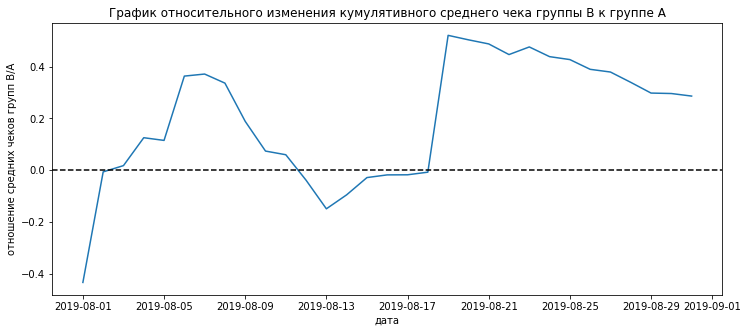

In [40]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on="date", right_on="date", how="left", suffixes=["A", "B"]
)

plt.figure(figsize=(12,5))
plt.ylabel('отношение средних чеков групп В/А')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('дата')
# cтроим отношение средних чеков
plt.plot(
    mergedCumulativeRevenue["date"],
    (mergedCumulativeRevenue["revenueB"] / mergedCumulativeRevenue["ordersB"])
    / (mergedCumulativeRevenue["revenueA"] / mergedCumulativeRevenue["ordersA"])
    - 1,
)

# добавляем ось X
plt.axhline(y=0, color="black", linestyle="--")
plt.show()

**Вывод:**
Исходя из обнаруженных фактов, тест следует остановить и признать успешным. При имеющихся данных сегмент B лучше сегмента A — по количеству сделанных заказов. Хотя и сумма среднего чека в обоих сегментах примерно одинаковая, но в группе В заказов совершают больше (примерно на 16%), чем в группе А. Что косвенно повлияет и на увеличение выручки компании.